# **Исследование поведения пользователей сервиса аренды самокатов**

**Описание проекта**

Популярному сервису аренды самокатов GoFast требуется помощь в проверке некоторых гипотез для увеличения выручки. Есть данные о некоторых пользователях из нескольких городов, а также об их поездках. 

**Задачи**

Проверить гипотезы:
* Тратят ли пользователи с подпиской больше времени на поездки? 
* Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
* Снизилось ли количество обращений в поддержку после обновления сервера, с которым взаимодействует мобильное приложение?

Решить задачи с помощью распределений:
* Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подобрать параметры распределения, описывающего эту ситуацию.
*  С помощью аппроксимации построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy import stats as st
from scipy. stats import norm
from scipy.stats import binom


**Структура проекта**

- [Описание данных;](#review)
- [Загрузка данных;](#loading_data)
- [Предобработка данных;](#preprocessing)
- [Исследовательский анализ данных;](#analysis)
- [Объединение данных;](#merging)
- [Подсчёт выручки;](#revenue)
- [Проверка гипотез;](#hypotheses)
- [Распределения;](#distribution)
- [Общий вывод.](#results)

## Описание данных <a id='review'></a>

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — `users_go.csv`**
* user_id - уникальный идентификатор пользователя
* name - имя пользователя
* age - возраст
* city - город
* subscription_type - тип подписки (free, ultra)

**Поездки - `rides_go.csv`**
* user_id - уникальный идентификатор пользователя
* distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date	дата совершения поездки

**Подписки — `subscriptions_go.csv`**
* subscription_type - тип подписки
* minute_price - стоимость одной минуты поездки по данной подписке
* start_ride_price - стоимость начала поездки
* subscription_fee - стоимость ежемесячного платежа


## Загрузка данных <a id='loading_data'></a>

**Пользователи — `users_go.csv`**

`Путь к файлу:` /datasets/users_go.csv

In [2]:
users =pd.read_csv('users_go.csv') 
display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Данные содержат 5 столбцов и 1565 строк. Таблица содержит данные об возрасте, городе проживания и типе подписки пользователей. 
Типы данных, представленных в таблице int64 и object. Пропусков в данных нет. 

**Поездки - `rides_go.csv`**

`Путь к файлу:` /datasets/rides_go.csv


In [3]:
rides =pd.read_csv('rides_go.csv') 
display(rides.head())
rides.info()
rides.columns

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Index(['user_id', 'distance', 'duration', 'date'], dtype='object')

Данные содержат 4 столбца и 18068 строк. Таблица содержит данные об типе подписки - стоимость одной минуты поездки по данной подписке, стоимость начала поездки и стоимость ежемесячного платежа. Типы данных, представленных в таблице float64, int64 и object.

**Подписки — `subscriptions_go.csv`**

`Путь к файлу:`    /datasets/subscriptions_go.csv

In [4]:
subscriptions =pd.read_csv('subscriptions_go.csv') 
display(subscriptions.head())
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Данные содержат 4 столбца и 2 строки. Таблица содержит данные об расстоянии, которое пользователь проехал в текущей сессии (в метрах), продолжительность сессии (в минутах), дата совершения поездки. Типы данных, представленных в таблице float64, int64(3) и object(3). Пропусков в данных нет. 

## Предобработка данных <a id='preprocessing'></a>

#### Типы данных
В таблице `rides_go` данные в столбце `date` имеет тип данных object, изменим его на тип datetime64.

In [5]:
rides['date']

0        2021-01-01
1        2021-01-18
2        2021-04-20
3        2021-08-11
4        2021-08-28
            ...    
18063    2021-11-04
18064    2021-11-16
18065    2021-11-18
18066    2021-11-27
18067    2021-12-29
Name: date, Length: 18068, dtype: object

In [6]:
rides['date'] = pd.to_datetime(rides['date'],format='%Y-%m-%d')

In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### Добавление в таблицу новых столбцов
Создадим новый столбец с номером месяца на основе столбца `date`.

In [8]:
rides['month'] = rides['date'].dt.month

In [9]:
rides.head(5)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### Работа с пропусками: и дубликатами**
Проверим наличие пропущенных значений и дубликатов в датафреймах и обработаем их.

In [10]:
users.duplicated().sum()

31

In [11]:
rides.duplicated().sum()

0

In [12]:
subscriptions.duplicated().sum()

0

При загрузке данных было выявлено, что пропусков в данных нет, однако таблица `users` содержит 31 строку с явными дубликатами. Удалим дубликаты.

In [13]:
users = users.drop_duplicates().reset_index(drop=True)
users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


Теперь таблица содержит 1534 строки.

## Исследовательский анализ данных <a id='analysis'></a>
Опишем и визуализируем общую информацию о пользователях и поездках.

#### Частота встречаемости городов


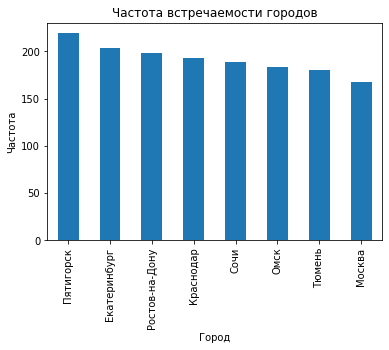

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

In [14]:
users['city'].value_counts().plot.bar()
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота')
plt.show()
users['city'].value_counts().sort_values()

**Вывод**
__________
Количество пользователей из разных городов варьируется от 168 до 219. Выборку можно считать репрезентативной, так как нет большого разброса между значениями. 
______

#### Соотношение пользователей с подпиской и без подписки


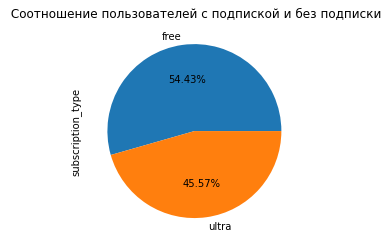

free     835
ultra    699
Name: subscription_type, dtype: int64

In [15]:
users['subscription_type'].value_counts().plot.pie(autopct='%1.2f%%')
plt.title(' Соотношение пользователей с подпиской и без подписки')
plt.show()
users['subscription_type'].value_counts()

In [16]:
type(users['subscription_type'].value_counts())

pandas.core.series.Series

**Вывод**
____
Пользователей без подписки больше, чем пользователей с подпиской  на 136 пользователей
___

#### Возраст пользователей


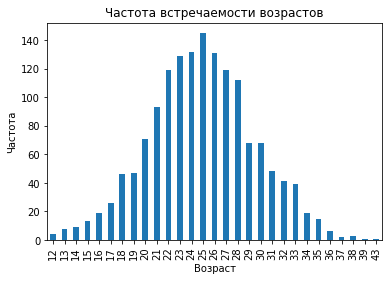

In [17]:
users['age'].value_counts().sort_index().plot.bar()
plt.title('Частота встречаемости возрастов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

**Вывод**
_______
Наибольшему количеству пользователей 25 лет. Так же более 100 значений из выборки это пользователи в возрасте от 22 до 28 лет, что логично - у пользователей этой возрастной группы наибольшие финансовые возможности и потребности в быстром и доступном передвижении по городу.  
Пользователей младше 18 и старше 32 совсем мало. 
_______

#### Расстояние, которое пользователь преодолел за одну поездку


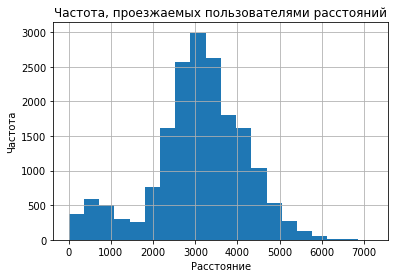

In [18]:
rides['distance'].hist(bins=20)
plt.title('Частота, проезжаемых пользователями расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

**Вывод**
________
Большинство пользователей проезжает за одну поездку около 3000м. Отдельные пики обнаруживаются также у значений до 1000м
____________

#### Продолжительность поездок

Text(0, 0.5, 'Частота')

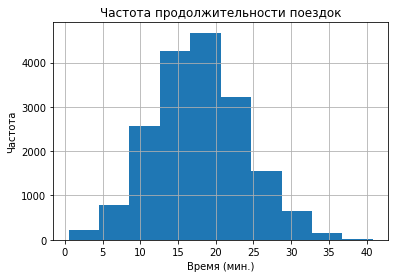

In [19]:
rides['duration'].hist()
plt.title('Частота продолжительности поездок')
plt.xlabel('Время (мин.)')
plt.ylabel('Частота')

**Вывод**
___
Пики наблюдаются у значений в 15-20 минут
___

## Объединение данных <a id='merging'></a>
Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [20]:
data = rides.merge(users,on='user_id', how='inner')
data = data.merge(subscriptions, on='subscription_type',how='inner')
data.head(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [21]:
print(f'Пропусков в таблице: {data.duplicated().sum()}, Размер таблицы: {data.shape[0]}')

Пропусков в таблице: 0, Размер таблицы: 18068


После объединения таблиц пропусков не возникло, и размер объединенной таблицы соответствует ожидаемому (18068 строк).

Создадим ещё два датафрейма: 
* С данными о пользователях без подписки;
* С данными о пользователях с подпиской.

In [22]:
ultra_sub = data.query('subscription_type == "ultra"')
ultra_sub.head(5) 

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [23]:
free_sub = data.query('subscription_type == "free"')
free_sub.head(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

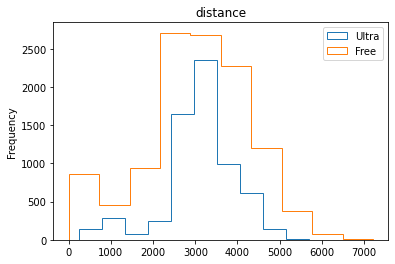

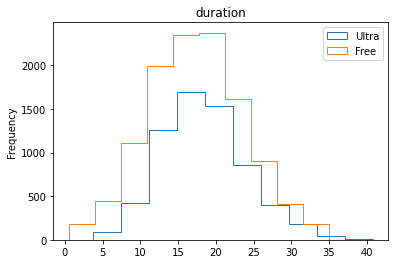

In [24]:
ultra_sub['distance'].plot(kind='hist',histtype='step',label='Ultra',legend=True, title='distance') 
free_sub['distance'].plot(kind='hist',histtype='step',label='Free',legend=True) 
plt.legend
plt.show()


ultra_sub['duration'].plot(kind='hist',histtype='step',label='Ultra',legend=True, title='duration') 
free_sub['duration'].plot(kind='hist',histtype='step',label='Free',legend=True) 
plt.show()


**Вывод**
_______
Пики в гистограммах с информацией о расстоянии наблюдаются у значений в 3000 м для пользователей с подпиской и от 2000 до 4000м для пользователей без подписки. Наблюдаются повышенные значения среди пользователей без подписки  от 0 до 1000 метров. Возможно, это связано с тем, что пользователи, у которых нет нужды пользоваться самокатом для перемещения на большие расстояния не оформляют подписку так как это будет дороже. 

По времени пользования выборки похожи - пики наблюдаются у значений в 15 и 20 минут. 
_______________

## Подсчёт выручки <a id='revenue'></a>
Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными таблицы `data`: 

Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [25]:
#округлим продолжительность каждой поездки в каждой строке исходного датафрейма  до следующего целого числа.
data['duration'] = np.ceil(data['duration'])
data.head(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [26]:
data_pivot = data.groupby(['user_id','month']).agg({'month':'count', 
                                                     'distance':'sum', 
                                                     'duration':'sum' })
data_pivot.columns = ['count','distance_sum','duration_sum' ]
data_pivot = data_pivot.reset_index()
data_pivot.head(5)

,user_id,month,count,distance_sum,duration_sum
0,1,1,2,7027.511294,42.0
1,1,4,1,754.159807,7.0
2,1,8,2,6723.470560,46.0
3,1,10,2,5809.911100,32.0
4,1,11,3,7003.499363,56.0


В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки:
* без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки —  8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки —  6 рублей;
    - стоимость старта — бесплатно.

In [27]:
#выделим данные о подписках всех пользователей
user_pivot = data.groupby('user_id')['minute_price','start_ride_price','subscription_fee'].mean()
user_pivot = user_pivot.reset_index()
user_pivot.head(5)

C:\Users\scheo\AppData\Local\Temp/ipykernel_1184/62024646.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_pivot = data.groupby('user_id')['minute_price','start_ride_price','subscription_fee'].mean()


,user_id,minute_price,start_ride_price,subscription_fee
0,1,6,0,199
1,2,6,0,199
2,3,6,0,199
3,4,6,0,199
4,5,6,0,199


In [28]:
#соединим данные о подписках пользователей и датафрейм с агрегированными данными о поездках 
data_pivot = data_pivot.merge(user_pivot, on='user_id')
data_pivot.head(5)

,user_id,month,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,6,0,199
1,1,4,1,754.159807,7.0,6,0,199
2,1,8,2,6723.470560,46.0,6,0,199
3,1,10,2,5809.911100,32.0,6,0,199
4,1,11,3,7003.499363,56.0,6,0,199


In [29]:
data_pivot['monthly_revenue'] = data_pivot['duration_sum']*data_pivot['minute_price']+ \
                                data_pivot['count']*data_pivot['start_ride_price']+ \
                                data_pivot['subscription_fee']
data_pivot.head(5)

,user_id,month,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,2,7027.511294,42.0,6,0,199,451.0
1,1,4,1,754.159807,7.0,6,0,199,241.0
2,1,8,2,6723.470560,46.0,6,0,199,475.0
3,1,10,2,5809.911100,32.0,6,0,199,391.0
4,1,11,3,7003.499363,56.0,6,0,199,535.0


In [30]:
#выделим таблицы с пользователями с подпиской и без в отдельные переменные
ultra = data_pivot.query('subscription_fee == 199 ')
free = data_pivot.query('subscription_fee == 0')

## Проверка гипотез <a id='hypotheses'></a>

При проверке гипотез статистическими методами будем использовать коэффициент статистической значимости равный 5%.

In [31]:
alpha = 0.05

#### Тратят ли пользователи с подпиской больше времени на поездки? 


Сформулируем нулевую гипотезу: средние значения времени поездок пользователей с подпиской и без подписки равны. 

H0 => mu1 = mu2

Альтернативная гипотеза: среднее время поездки пользователя с подпиской больше, чем у пользователя без подписки

H1 => mu1 > mu2 

In [32]:
free_duration = free_sub['duration']
ultra_duration = ultra_sub['duration']

ttest_one = st.ttest_ind(ultra_duration, 
                       free_duration,
                       equal_var = False)
if ttest_one.pvalue < alpha:
    print(f'p-value = {ttest_one.pvalue}, Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print(f'p-value = {ttest_one.pvalue}, Нет оснований отвергать нулевую гипотезу')

p-value = 1.1351562754257953e-36, Нулевая гипотеза отвергается в пользу альтернативной


**Вывод**
_____
Значение p-value значительно  меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки. Так как стоимость поездки зависит от времени в пути, то пользователи с подпиской «выгоднее» для компании.
______

#### Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?


Нулевую гипотезу сформулируем как равенство среднего значения расстояния, которое проезжают пользователи с подпиской за одну поездку 3130 метрам.

H0 => mu1 = 3130

Альтернативная гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, менее 3130 метров

H1 => mu1 < 3130 

In [33]:
ultra_distance = ultra_sub['distance']
ttest_two = st.ttest_1samp(ultra_distance, 3130, alternative = 'less')
if ttest_two.pvalue < alpha:
    print(f'p-value = {ttest_two.pvalue}, Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print(f'p-value = {ttest_two.pvalue}, Нет оснований отвергать нулевую гипотезу')
    

p-value = 0.08046311521502145, Нет оснований отвергать нулевую гипотезу


**Вывод**
_________
Оснований отвергать нулевую гипотезу нет, так как вероятность того, что пользователи проезжают 3130 м и более лежит в пределах статистической значимости выборки. 
Так как расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката, можно сказать, что необходимо обратить внимание на количество самокатов в городах или качество сервисного обслуживания. 
_______

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? 


Нулевая гипотеза: помесячные выручки от пользователей с подпиской и без одинаковы

H0 => mu1 = mu2

Альтернативная гипотеза: выручка от пользователей с подпиской больше

H1 => mu1 > mu2

In [34]:
free_revenue = free['monthly_revenue']
ultra_revenue = ultra['monthly_revenue']

ttest_three = st.ttest_ind(ultra_revenue,free_revenue,alternative='greater')
if ttest_three.pvalue < alpha:
    print(f'p-value = {ttest_three.pvalue}, Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print(f'p-value = {ttest_three.pvalue}, Нет оснований отвергать нулевую гипотезу')

p-value = 1.8850394384715216e-31, Нулевая гипотеза отвергается в пользу альтернативной


 **Вывод**
_________
Есть основания полагать, что пользователи с подпиской приносят больше прибыли бизнесу, чем пользователи без подписки. 
_______

#### Снизилось ли количество обращений в поддержку после обновления сервера, с которым взаимодействует мобильное приложение?


**Задача:** Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

**Ответ:**

В данном случае необходимо рассматривать гипотезу о равенстве средних для зависимых выборок. Проверяем равенство среднего значения генеральной совокупности до и после изменения

`Нулевая гипотеза` будет звучать так: среднее количество обращений до обновления равно среднему количеству обращений после обновления (mu1=mu2)

`Альтернативная гипотеза`: среднее количество обращений до обновления не равно среднему количеству обращений после обновления (mu1≠mu2)

Для решения используем метод `st.ttest_rel()`, в качестве аргументов передаем данные о количестве пользователей до и после обновления. 

## Распределения <a id='distribution'></a>

#### Задача 7.1 
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум `100` существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают  `10 % пользователей`. Выясните, `какое минимальное количество промокодов нужно разослать`, чтобы вероятность не выполнить план была примерно  `5 %`. 
Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


Известно, что 10% пользователей продлевают подписку после пробного периода, соответственно вероятность "успеха" p=0.1 Построим график биномиального распределения для целевого количества подписчиков n=100.

Минимальное количество промокодов для вероятности не выполнения плана примерно 5%: 120


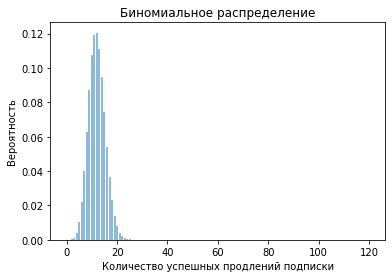

In [35]:
# Уровень значимости
alpha = 0.05

# Вероятность продления подписки
p = 0.10

# Минимальное количество клиентов, которые должны продлить подписку
n_success = 100

# Начинаем с небольшого числа промокодов
n_promo = 100

# Расчет биномиального распределения до тех пор, пока сумма вероятностей не выполнения плана не станет меньше alpha
while True:
    # Вероятность не продления подписки
    p_not_success = 1 - p
    # Функция биномиального распределения (вероятность того, что не менее n_success клиентов не продлят подписку)
    prob_not_success = st.binom.cdf(n_success - 1, n_promo, p_not_success)
    if prob_not_success <= alpha:
        break
    else:
        n_promo += 10

# Вывод результата
print(f"Минимальное количество промокодов для вероятности не выполнения плана примерно 5%: {n_promo}")

# Построение графика биномиального распределения
x = range(n_promo + 1)
plt.bar(x, [st.binom.pmf(i, n_promo, p) for i in x], align='center', alpha=0.5)
plt.title('Биномиальное распределение')
plt.xlabel('Количество успешных продлений подписки')
plt.ylabel('Вероятность')
plt.show()

**Вывод**
___________
Таким образом,  нужно разослать минимум 120 промокодов, чтобы вероятность не выполнить план была примерно 5 %.
___________

#### Задача 7.2
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

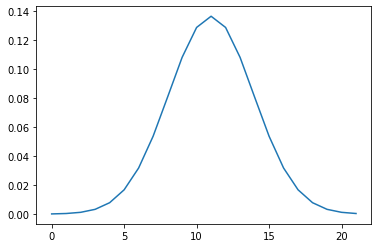

Условие выполняется


In [36]:
 # задаём параметры биномиального распределения
n = 50
p = 0.22
#зададим границы распределения от mu-4s до mu+4s
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
# зададим набор значений биномиальной величины на выбранном промежутке от left до right
x = list(range( left, right))

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
plt.plot(norm.pdf(x, mu, sigma))
plt.show()
 


# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')


In [37]:
n = 1000000 # параметры биномиального распределения
p = 0.4 

mu = n*p #  параметры нормального распределения
sigma = sqrt(n * p * (1 - p))  

distr = st.norm(mu,sigma) # нормальное распределение
result =distr.cdf(399500) # вероятность
print(result)

0.15371708296369768


**Вывод**
___
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 15,37%
___


## Общий вывод <a id='results'></a>

**На этапе предобработки в данных были выявлены следующие проблемы:**
* В таблице `rides_go` тип данных в столбце `date` был изменен на  datetime64;
* В датасет был добавлен новый столбец с номером месяца на основе столбца `date`;
* Были удалены явные дубликаты из таблицы `users` (31 строка).

**При исследовательском анализе и  проверке гипотез были сделаны следующие выводы:**
* Количество пользователей из разных городов в выборке от 168 до 219;
* Основная возрастная категория пользователей — это люди от 25 до 28 лет;
* В среднем продолжительность поездки составляет 15-20 минут;
* Пользователи с подпиской являются наиболее "выгодными" для компании так как они тратят больше времени на поездки и приносят больше прибыли, чем пользователи без подписки;
* Пользователи без подписки чаще передвигаются на самокате на малые расстояния ( до 1000 метров);
* Так же было выявлено, что в среднем пользователи проезжают около 3130м и более, что является критичным значением для износа самокатов.


**При решении задач для отдела маркетинга GoFast были получены следующие результаты:**
*  В ходе акции с раздачей промокодов на один бесплатный месяц чтобы как минимум 100 существующих клиентов продлили подписку необходимо разослать не менее 120 промокодов. 
* Вероятность того, что  push-уведомления в мобильном приложении откроют не более 399,5 тыс. пользователей составляет 15,37%

**Рекомендации для бизнеса**
1. Учитывая, что пользователи с подпиской приносят больше прибыли, рекомендуется активно продвигать подписочную модель. Это может включать в себя предложения, целенаправленные на увеличение числа подписчиков через бонусные программы, персонализированные предложения и улучшение условий для подписчиков.

2. Учитывая, что пользователи без подписки чаще используют самокаты на небольшие расстояния, компания может сосредоточить усилия на оптимизации использования самокатов в городах, где это актуально. Например, расширение зон обслуживания, снижение тарифов на короткие поездки и т.д.

3. На основе результатов о критичном значении среднего пробега пользователей рекомендуется уделить внимание управлению износом самокатов. Это может включать в себя планы по обновлению парка самокатов, ремонт и техническое обслуживание для предотвращения выхода самокатов из строя.